In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics.pairwise import cosine_similarity

# Path to your dataset
image_dir = "/kaggle/input/open-images-2019-object-detection/test"  # Update with your image directory path


2024-08-20 08:44:54.998106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 08:44:54.998331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 08:44:55.177436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# Define the InceptionV3 model
def create_inceptionv3_model(input_shape=(224, 224, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[-45:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

# Instantiate the model
model = create_inceptionv3_model()

# Function to create a generator for loading images in batches
def image_generator(dataset_dir, img_size=(224, 224), batch_size=64):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None,  # No labels are required
        shuffle=False,  # Shuffle should be False to maintain order of file paths
        classes=['.']  # Use only files directly in the directory, no subfolders
    )
    
    return generator

# Create a generator
batch_size = 64
img_size = (224, 224)
image_gen = image_generator(image_dir, img_size, batch_size)

# Store paths for reference
image_paths = image_gen.filepaths

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 99999 images belonging to 1 classes.


In [3]:

# Generate feature embeddings for all images
def get_feature_embeddings(generator):
    return model.predict(generator, verbose=1)

# Get feature vectors
feature_vectors = get_feature_embeddings(image_gen)

# Function to find similar images based on cosine similarity
def search_similar_images(query_vector, feature_vectors, top_n=5):
    similarities = cosine_similarity(query_vector, feature_vectors)[0]
    indices = np.argsort(similarities)[-top_n:][::-1]
    return indices

# Preprocess uploaded image
def preprocess_image(image):
    image = image.convert('RGB')  # Convert to RGB if it's grayscale
    image = image.resize((224, 224))  # Resize the image
    image = np.array(image) / 255.0  # Normalize the image
    return image

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6358s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


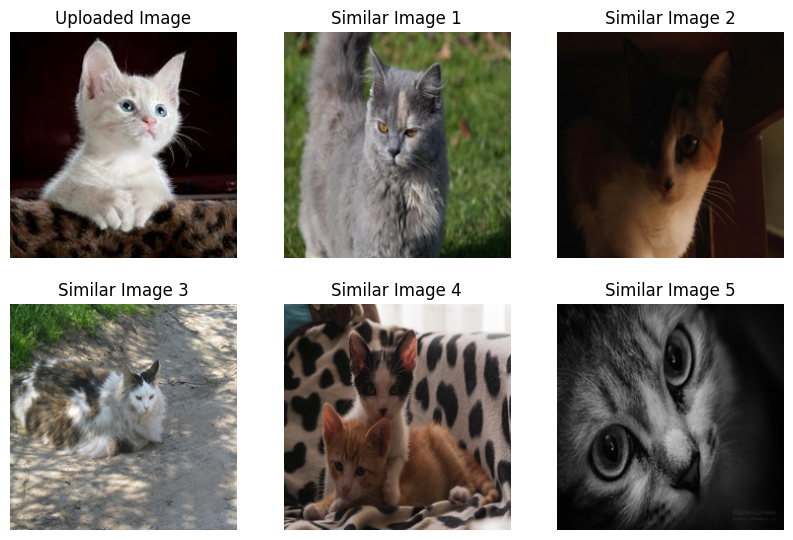

In [4]:

# Path to the uploaded image
uploaded_image_path = '/kaggle/input/test-j/cat.jpg'  # Update with your image path

# Load and preprocess the uploaded image
img = Image.open(uploaded_image_path)
img = preprocess_image(img)
query_vector = model.predict(img.reshape(1, 224, 224, 3))

# Find similar images
indices = search_similar_images(query_vector, feature_vectors)
similar_image_paths = [image_paths[i] for i in indices]

# Display the uploaded image
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(np.array(img))
plt.title("Uploaded Image")
plt.axis('off')

# Display similar images
for i, img_path in enumerate(similar_image_paths):
    similar_img = Image.open(img_path)
    similar_img = preprocess_image(similar_img)
    plt.subplot(3, 3, i + 2)
    plt.imshow(np.array(similar_img))
    plt.title(f"Similar Image {i+1}")
    plt.axis('off')

plt.show()


In [5]:

# Save feature vectors to a file
np.save('/kaggle/working/feature_vectors.npy', feature_vectors)

# Save image paths for reference
with open('/kaggle/working/image_paths.txt', 'w') as f:
    for path in image_paths:
        f.write(f"{path}\n")

# Save model weights
model.save_weights('/kaggle/working/inceptionv3_features_model.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


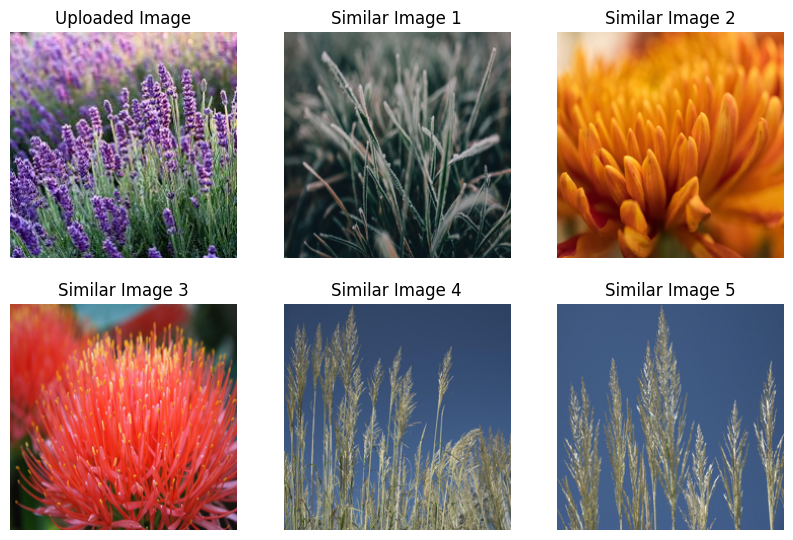

In [6]:

# Path to the uploaded image
uploaded_image_path = '/kaggle/input/test-j/lavender.jpg'  # Update with your image path

# Load and preprocess the uploaded image
img = Image.open(uploaded_image_path)
img = preprocess_image(img)
query_vector = model.predict(img.reshape(1, 224, 224, 3))

# Find similar images
indices = search_similar_images(query_vector, feature_vectors)
similar_image_paths = [image_paths[i] for i in indices]

# Display the uploaded image
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(np.array(img))
plt.title("Uploaded Image")
plt.axis('off')

# Display similar images
for i, img_path in enumerate(similar_image_paths):
    similar_img = Image.open(img_path)
    similar_img = preprocess_image(similar_img)
    plt.subplot(3, 3, i + 2)
    plt.imshow(np.array(similar_img))
    plt.title(f"Similar Image {i+1}")
    plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


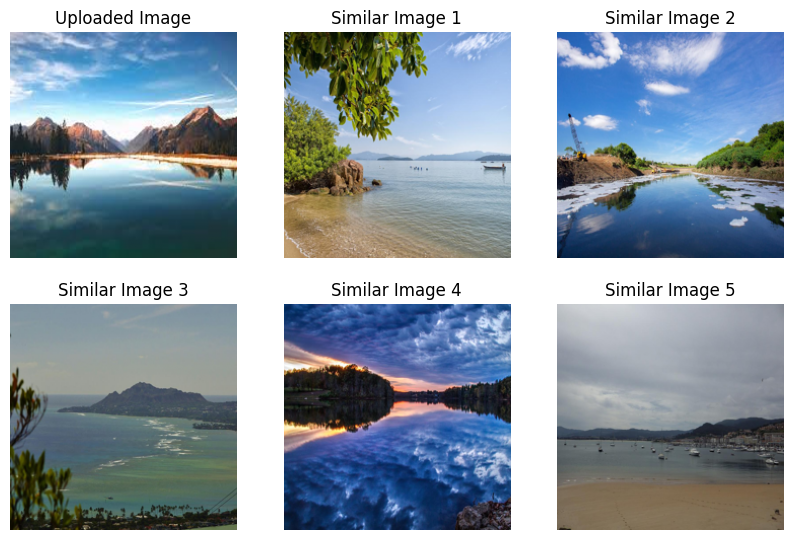

In [7]:

# Path to the uploaded image
uploaded_image_path = '/kaggle/input/test-j/scenary.jpg'  # Update with your image path

# Load and preprocess the uploaded image
img = Image.open(uploaded_image_path)
img = preprocess_image(img)
query_vector = model.predict(img.reshape(1, 224, 224, 3))

# Find similar images
indices = search_similar_images(query_vector, feature_vectors)
similar_image_paths = [image_paths[i] for i in indices]

# Display the uploaded image
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(np.array(img))
plt.title("Uploaded Image")
plt.axis('off')

# Display similar images
for i, img_path in enumerate(similar_image_paths):
    similar_img = Image.open(img_path)
    similar_img = preprocess_image(similar_img)
    plt.subplot(3, 3, i + 2)
    plt.imshow(np.array(similar_img))
    plt.title(f"Similar Image {i+1}")
    plt.axis('off')

plt.show()
